In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-c9fd4cb2-40c3-e6ec-3f83-509c99621fc6)


In [2]:
# from drive
!cp -r ./drive/MyDrive/single-person-pose-estimation/temp ./

In [17]:
#!unzip ./drive/MyDrive/single-person-pose-estimation/dataset/tfrecords.zip

Archive:  ./drive/MyDrive/single-person-pose-estimation/dataset/tfrecords.zip
   creating: dataset/tfrecords/
   creating: dataset/tfrecords/valid/
  inflating: dataset/tfrecords/valid/file_valid_01-2048.tfrec  
  inflating: dataset/tfrecords/valid/file_valid_02-2048.tfrec  
  inflating: dataset/tfrecords/valid/file_valid_00-2048.tfrec  
  inflating: dataset/tfrecords/valid/file_valid_03-208.tfrec  
   creating: dataset/tfrecords/train/
  inflating: dataset/tfrecords/train/file_train_36-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_19-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_31-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_62-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_10-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_69-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_61-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_48-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter, maximum_filter

In [2]:
import sys
import time
from datetime import datetime, timedelta
sys.path.append('/content/drive/MyDrive/single-person-pose-estimation')
from configs import default_config as cfg

In [3]:
model = tf.keras.models.load_model('drive/MyDrive/single-person-pose-estimation/trained_models/first_Adam_RME')

/usr/local/lib/python3.7/dist-packages/keras/layers/core/lambda_layer.py:305: UserWarning: model.hourglass is not loaded, but a Lambda layer uses it. It may cause errors.
  'function_type')


In [4]:
from model.hourglass import HourGlassNet

In [5]:
HG = HourGlassNet(cfg.NUM_KEYPOINTS, cfg.HG_NUM_STACKS, cfg.HG_NUM_FILTERS, 
              (cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH, 3), 
              (cfg.LABEL_HEIGHT, cfg.LABEL_WIDTH, cfg.NUM_KEYPOINTS))
model = HG.create_hg_model()

Created HourGlassmodel:
    1. 4 stacks.
    2. 12080324 parameters. Call object.get_summary() for more detail.
    


In [6]:
from dataset_builder import DatasetBuilder

In [7]:
ds_builder = DatasetBuilder(cfg)

Train dataset with 149813 examples.
Valid dataset with 6352 examples.


In [8]:
from trainer import Trainer

In [9]:
trainer = Trainer(model, ds_builder, epochs = 10, learning_rate = 1e-3, config = cfg)

In [10]:
model = trainer.get_best_weights_model()

Loading best weights from temp/checkpoints
Loaded: E75-14-05-2022.cpkt.index


In [11]:
ds = ds_builder.get_ds_prediction()

In [12]:
it = iter(ds)

In [13]:
images_batch, heatmaps_batch = next(it)

In [14]:
pred = model.predict(images_batch)

In [15]:
print(pred[-1].shape)
print(heatmaps_batch.shape)

(16, 64, 64, 17)
(16, 64, 64, 17)


In [29]:
model.evaluate(ds, steps = np.ceil(ds_builder.num_valid_examples // cfg.BATCH_SIZE))

397/397 [==============================] - 58s 122ms/step - loss: 0.0025 - heatmap1_loss: 6.9545e-04 - heatmap2_loss: 6.2885e-04 - heatmap3_loss: 6.1045e-04 - heatmap4_loss: 6.0755e-04


[0.0025422933977097273,
 0.0006954523851163685,
 0.0006288482691161335,
 0.0006104467320255935,
 0.0006075462442822754]



---

Test a diff way to get coordinates

In [42]:
def plot_hm(heatmap):
  plt.figure(figsize=(10, 10))
  plt.imshow(heatmap, alpha = 0.5)

In [59]:
truthground = tf.image.resize(heatmaps_batch[0], (256, 256))[:, :, 9]
predicted = tf.image.resize(pred[-1][0], (256, 256))[:, :, 9]

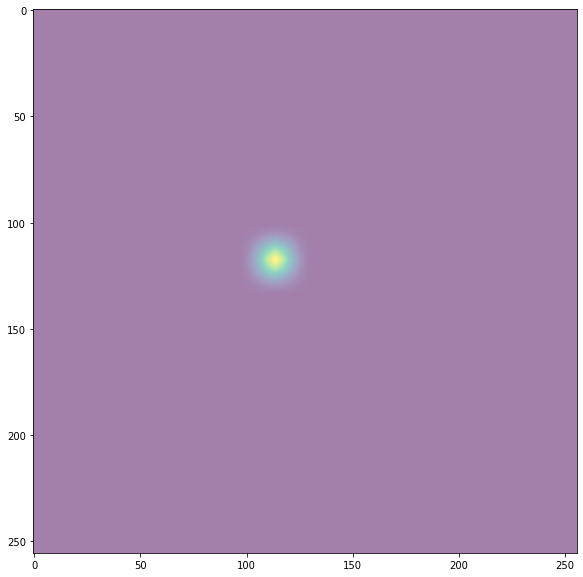

In [60]:
plot_hm(truthground)

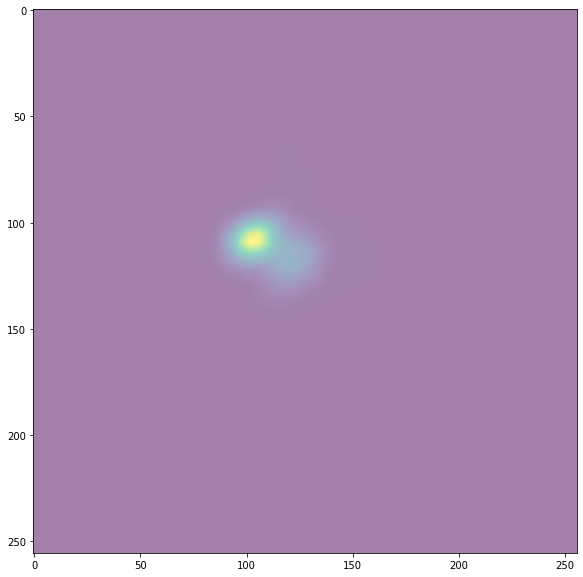

In [61]:
plot_hm(predicted)

In [62]:
def _non_max_supression(plain, threshold, windowSize=3):
    # Clear values less than threshold
    under_thresh_indices = plain < threshold
    plain[under_thresh_indices] = 0
    return plain * (plain == maximum_filter(plain, footprint=np.ones((windowSize, windowSize))))

In [64]:
truthground_supressed =_non_max_supression(truthground.numpy(), 0.2)
predicted_supressed = _non_max_supression(predicted.numpy(), 0.2)

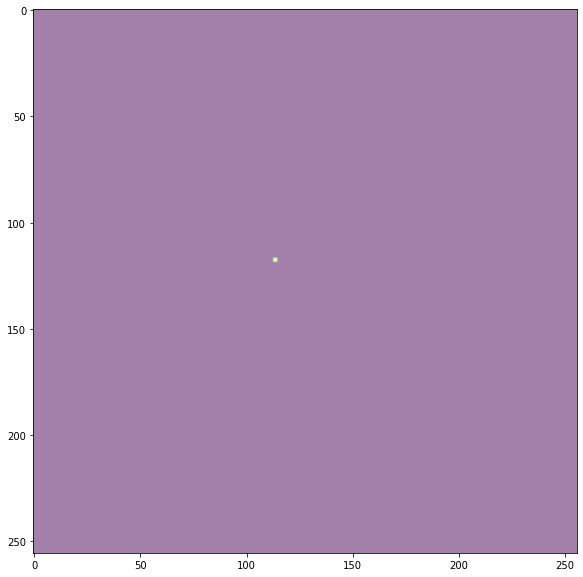

In [65]:
plot_hm(truthground_supressed)

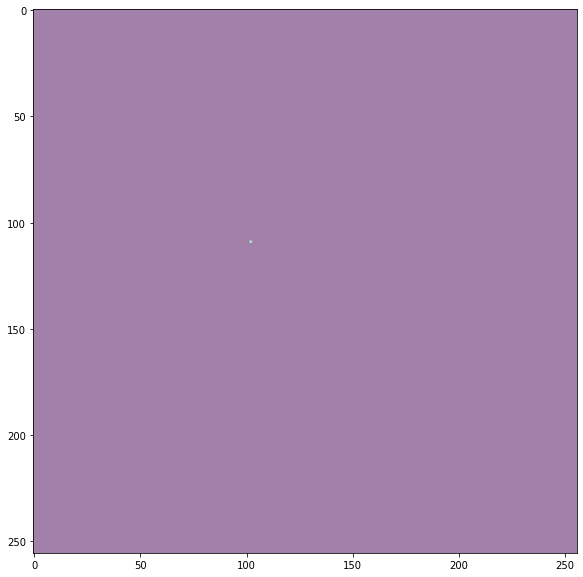

In [66]:
plot_hm(predicted_supressed)

In [67]:
tg_y, tg_x = np.unravel_index(np.argmax(truthground_supressed), truthground_supressed.shape)
pred_y, pred_x = np.unravel_index(np.argmax(predicted_supressed), predicted_supressed.shape)

In [68]:
tg_y, tg_x

(117, 113)

In [69]:
pred_y, pred_x

(109, 102)

In [73]:
conf = predicted_supressed[pred_y, pred_x]
conf

0.3066479

In [79]:
resized = tf.image.resize(pred[-1][0], (256, 256))

In [81]:
resized.shape

TensorShape([256, 256, 17])

In [117]:
def find_max_coords(heatmaps):
  flatten_heatmaps = tf.reshape(heatmaps, (256*256, 17))
  indices = tf.math.argmax(flatten_heatmaps, axis = 0)
  x = indices%256
  y = indices//256
  conf = tf.math.reduce_max(flatten_heatmaps, axis = 0)
  return x, y, conf

In [118]:
x, y, conf = find_max_coords(resized)

In [84]:
print(x[9], y[9], conf[9], sep = ', ')

tf.Tensor(102, shape=(), dtype=int64), tf.Tensor(109, shape=(), dtype=int64), tf.Tensor(0.3066479, shape=(), dtype=float32)


NOT much of  a difference



---



In [16]:
def find_max_coords(heatmaps):
  flatten_heatmaps = tf.reshape(heatmaps, (64*64, 17))
  indices = tf.math.argmax(flatten_heatmaps, axis = 0)
  x = indices%64
  y = indices//64
  conf = tf.math.reduce_max(flatten_heatmaps, axis = 0)
  return x, y, conf
 

In [17]:
def heatmaps_to_keypoints(heatmaps):
  # input shape (64, 64, 17)
  flatten_heatmaps = tf.reshape(heatmaps, (64*64, 17)).numpy()
  x_coords = []
  y_coords = []
  confs = []
  for i in range(17):
    hm = flatten_heatmaps[:, i]
    index = np.argmax(hm)
    x = index%64
    y = index//64
    conf = hm[y*64 + x]
    if conf > 0.2:
      x_coords.append(x)
      y_coords.append(y)
      confs.append(conf)
    else:
      x_coords.append(0)
      y_coords.append(0)
      confs.append(0)
  
  return x_coords, y_coords, confs

In [18]:
x_pred, y_pred, c_pred = find_max_coords(pred[-1][0])
print(x_pred)
print(y_pred)
print(c_pred)

tf.Tensor([28 28 28 29 29 32 32 31 31 25 25 34 34 34 35 37 37], shape=(17,), dtype=int64)
tf.Tensor([11 10 10 10 10 14 14 21 21 27 27 31 31 43 43 55 55], shape=(17,), dtype=int64)
tf.Tensor(
[0.18057589 0.12577386 0.10158087 0.27504972 0.21174408 0.54726714
 0.49519762 0.38403717 0.30360073 0.3105754  0.33258304 0.41172382
 0.37788308 0.32722113 0.3308746  0.37929237 0.3954908 ], shape=(17,), dtype=float32)


In [19]:
x_pred, y_pred, confs  = heatmaps_to_keypoints(pred[-1][0])
print(x_pred)
print(y_pred)
print(confs)

[0, 0, 0, 29, 29, 32, 32, 31, 31, 25, 25, 34, 34, 34, 35, 37, 37]
[0, 0, 0, 10, 10, 14, 14, 21, 21, 27, 27, 31, 31, 43, 43, 55, 55]
[0, 0, 0, 0.27504972, 0.21174408, 0.54726714, 0.49519762, 0.38403717, 0.30360073, 0.3105754, 0.33258304, 0.41172382, 0.37788308, 0.32722113, 0.3308746, 0.37929237, 0.3954908]


In [20]:
x_tr, y_tr, c = find_max_coords(heatmaps_batch[0])
print(x_tr)
print(y_tr)
print(c)

tf.Tensor([27 28  0 30  0 32 34 31 28 28 24 34 36 34 37 37 39], shape=(17,), dtype=int64)
tf.Tensor([11 10  0 10  0 13 13 22 24 29 27 31 30 44 43 55 54], shape=(17,), dtype=int64)
tf.Tensor([1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], shape=(17,), dtype=float32)


In [21]:
num_iters = int(np.ceil(6352//16))
it = iter(ds)
predicted_kps = []

In [22]:
for i in range(num_iters):
  images_batch, heatmaps_batch = next(it)
  pred = model.predict(images_batch)
  #only take prediction of last stage
  for p in pred[-1]: # should be 16
    x, y, conf = heatmaps_to_keypoints(p)
    predicted_kps.append([x, y, conf]) # need confidence score
  #clean up after
  tf.keras.backend.clear_session()

In [23]:
print(len(predicted_kps))

6352


In [24]:
predicted_kps[0]

[[0, 0, 0, 29, 29, 32, 32, 31, 31, 25, 25, 34, 34, 34, 35, 37, 37],
 [0, 0, 0, 10, 10, 14, 14, 21, 21, 27, 27, 31, 31, 43, 43, 55, 55],
 [0,
  0,
  0,
  0.27504972,
  0.21174408,
  0.54726714,
  0.49519762,
  0.38403717,
  0.30360073,
  0.3105754,
  0.33258304,
  0.41172382,
  0.37788308,
  0.32722113,
  0.3308746,
  0.37929237,
  0.3954908]]

In [25]:
ann_ids, image_ids, gt_keypoints, undo_bbox, coco_url, raw_img_shape = ds_builder.get_metadata_prediction()

In [26]:
len(gt_keypoints)

6352

In [27]:
coco_url[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'http://images.cocodataset.org/val2017/000000000139.jpg'>

In [27]:
from urllib.request import urlopen
import json
import pandas as pd

In [95]:
x_pred.numpy()

array([28, 28, 28, 29, 29, 32, 32, 31, 31, 25, 25, 34, 34, 34, 35, 37, 37])

In [96]:
undo_bbox[0][0].numpy()

353.06876

In [97]:
raw_img_shape[0][0]

<tf.Tensor: shape=(), dtype=int64, numpy=172>

In [98]:
raw_width = raw_img_shape[0][0].numpy() 
raw_height = raw_img_shape[0][1].numpy() 

In [99]:
x_pred_undo_bbox = x_pred.numpy() * (raw_width/64) + undo_bbox[0][0].numpy()
y_pred_undo_bbox = y_pred.numpy() * (raw_height/64) + undo_bbox[0][1].numpy()

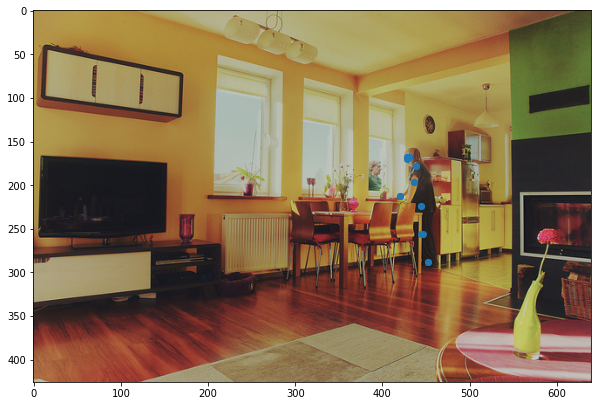

In [100]:
f = urlopen("http://images.cocodataset.org/val2017/000000000139.jpg")
a = plt.imread(f, format = 'jpeg')
plt.figure(figsize =(10,10))
plt.imshow(a)
plt.scatter(x_pred_undo_bbox , y_pred_undo_bbox , marker = "o") # for heatmap size
plt.show()

In [28]:
def create_oks_obj(ann_id, image_id, pred_kpts, score):
  oks_obj = {}
  oks_obj['image_id'] = image_id
  oks_obj['ann_id'] = ann_id
  oks_obj['category_id'] = 1
  oks_obj['keypoints'] = pred_kpts
  oks_obj['score'] = score
  return oks_obj

In [29]:
predicted_kps[0]

[[0, 0, 0, 29, 29, 32, 32, 31, 31, 25, 25, 34, 34, 34, 35, 37, 37],
 [0, 0, 0, 10, 10, 14, 14, 21, 21, 27, 27, 31, 31, 43, 43, 55, 55],
 [0,
  0,
  0,
  0.27504972,
  0.21174408,
  0.54726714,
  0.49519762,
  0.38403717,
  0.30360073,
  0.3105754,
  0.33258304,
  0.41172382,
  0.37788308,
  0.32722113,
  0.3308746,
  0.37929237,
  0.3954908]]

In [103]:
ann_ids[0]

230831

In [104]:
image_ids[0]

139

In [105]:
np.mean(predicted_kps[0][2].numpy())

0.32296887

In [44]:
list_of_prediction = []
for ann_id, image_id, pred, img_shape, bbox in zip(ann_ids, image_ids, predicted_kps, raw_img_shape, undo_bbox):
  # ann id and iamge id are alreay int
  # TODO: conver other to their respect tyopes
  width = img_shape[0].numpy()
  height = img_shape[1].numpy()
  bbox_x = bbox[0].numpy()
  bbox_y = bbox[1].numpy()
  coco_kpts = []
  x_coords = pred[0]
  y_coords = pred[1]
  score = pred[2]
  for x, y in zip(x_coords, y_coords):
    coco_kpts.append(int(x * (width/64) + bbox_x))
    coco_kpts.append(int(y* (height/64) + bbox_y))
    coco_kpts.append(int(1))
  oks_obj = create_oks_obj(ann_id, image_id, coco_kpts, float(np.mean(score)))
  list_of_prediction.append(oks_obj)

In [45]:
with open("result.json", "w") as outfile:
    json.dump(list_of_prediction, outfile)

In [46]:
list_of_prediction[0]

{'ann_id': 230831,
 'category_id': 1,
 'image_id': 139,
 'keypoints': [353,
  140,
  1,
  353,
  140,
  1,
  353,
  140,
  1,
  431,
  167,
  1,
  431,
  167,
  1,
  439,
  177,
  1,
  439,
  177,
  1,
  436,
  196,
  1,
  436,
  196,
  1,
  420,
  212,
  1,
  420,
  212,
  1,
  444,
  223,
  1,
  444,
  223,
  1,
  444,
  255,
  1,
  447,
  255,
  1,
  452,
  288,
  1,
  452,
  288,
  1],
 'score': 0.2989729809410432}

In [33]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [34]:
cocoGt= COCO('/content/drive/MyDrive/single-person-pose-estimation/dataset/annotations/person_keypoints_val2017.json')

loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


In [47]:
cocoDt = cocoGt.loadRes('result.json')

Loading and preparing results...
DONE (t=0.30s)
creating index...
index created!


In [48]:
annType = "keypoints"
cocoEval = COCOeval(cocoGt,cocoDt,annType)
cocoEval.params.imgIds = image_ids
cocoEval.params.catIds = [1] # Person category
cocoEval.evaluate()
cocoEval.accumulate()
print('\nSummary: ')
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=4.19s).
Accumulating evaluation results...
DONE (t=0.09s).

Summary: 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.208
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.424
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.185
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.214
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.219
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.284
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.528
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.270
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.246
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.337


Summary: 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.545
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.257
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.292
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.376
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.668
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.372
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.340
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.426

In [113]:
 stats = cocoEval.stats
 stats

array([0.27426613, 0.54524923, 0.25707448, 0.27085883, 0.29230932,
       0.37610202, 0.66782116, 0.37232368, 0.33990713, 0.42634708])